In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import functools

from datetime import timedelta

import jax
import xarray

import numpy as np
import jax.numpy as jnp

from graphcast import xarray_jax

from data_loading import load_data
from model_running import (
    multi_step_forward_jit, forward_fn_jitted, build_static_data_selector,
    approx_forward_fn_jitted, task_config,
)
from attacks import add_perturbation, our_attack

In [22]:
import json

with open("data/geoBoundariesCGAZ_ADM0.geojson", "r") as f:
    boundary_data = json.load(f)

In [25]:
def smooth(points):
    new_points = [points[0]]
    def distance(p1, p2):
        return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5
    for point in points[1:]:
        if distance(point, new_points[-1]) < 0.2:
            continue
        new_points.append(point)
    return new_points

def to_svg_path(points):
    assert len(points) > 1
    s = f"M{points[0][0]} {-points[0][1]}"
    for point in points[1:]:
        s += f" L{point[0]} {-point[1]}"
    s += " Z"
    return f'<path d="{s}" stroke="black" fill="#eee" fill-opacity="1.0"/>'

def filter_boundaries(feature):
    def is_in_bounds(coord):
        lon, lat = coord
        # 5, 30, 65, 100
        if lat < -10 or lat > 80:
            return False
        if lon < 50 or lon > 120:
            return False
        return True
    return list(filter(
        lambda boundary: len(boundary) > 5 and any(is_in_bounds(coord) for coord in boundary),
        (
            smooth(boundary) if feature["geometry"]["type"] == "Polygon" else smooth(boundary[0])
            for boundary in feature["geometry"]["coordinates"])
    ))

In [26]:
all_paths = sum(
    (
        list(
            map(to_svg_path, filter_boundaries(boundaries)
            )
        )
        for boundaries in boundary_data["features"]
    ), start=[]
)

In [71]:
def general_loss_fn(
        rng,
        inputs,
        targets,
        forcings,
        forward_fn,
        variable_selection_fn,
        region_selection_fn,
    ):
    denoised_predictions = multi_step_forward_jit(
        rng,
        inputs,
        targets,
        forcings,
        forward_fn
    ).isel(time=-1)

    # select target variable
    target = variable_selection_fn(denoised_predictions)

    # select target region
    target = xarray_jax.unwrap_data(target, require_jax=True)
    target = region_selection_fn(target)

    loss = jnp.mean(target)
    return loss

# no jit, as it does not provide a speedup in this case
precise_loss_fn = lambda rng, i, t, f, s, v: general_loss_fn(rng, i, t, f, forward_fn_jitted, v, s)

def adv_grads_fn(rng, inputs, targets, forcings, approximation_steps, variable_selection_fn, region_selection_fn):
    forward_fn = functools.partial(approx_forward_fn_jitted, approximation_steps=approximation_steps)
    def _aux(rng, i, t, f):
        loss = general_loss_fn(
            rng, i, t, f,
            forward_fn=forward_fn,
            variable_selection_fn=variable_selection_fn,
            region_selection_fn=region_selection_fn,
        )
        return loss

    loss, grads = jax.value_and_grad(
        _aux,
        argnums=1,
    )(rng, inputs, targets, forcings)
    return loss, grads
adv_grads_fn_jitted = jax.jit(adv_grads_fn, static_argnums=(4,5,6))

In [4]:
era5 = xarray.open_zarr("gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr")

In [5]:
era5 = era5.isel(time=slice(1, None, 2))

In [10]:
single_sample = era5.isel(time=0).compute()
single_sample = single_sample.rename_dims(dict(latitude="lat", longitude="lon"))
single_sample = single_sample.rename_vars(dict(latitude="lat", longitude="lon"))
single_sample = single_sample.isel(lat=slice(None, None, -1))

In [6]:
inputs, targets, forcings = load_data(era5, "2020-05-18T06:00:00", task_config, lead_time=timedelta(days=2.5))

In [7]:
import matplotlib.pyplot as plt

Array(110.94387, dtype=float32)

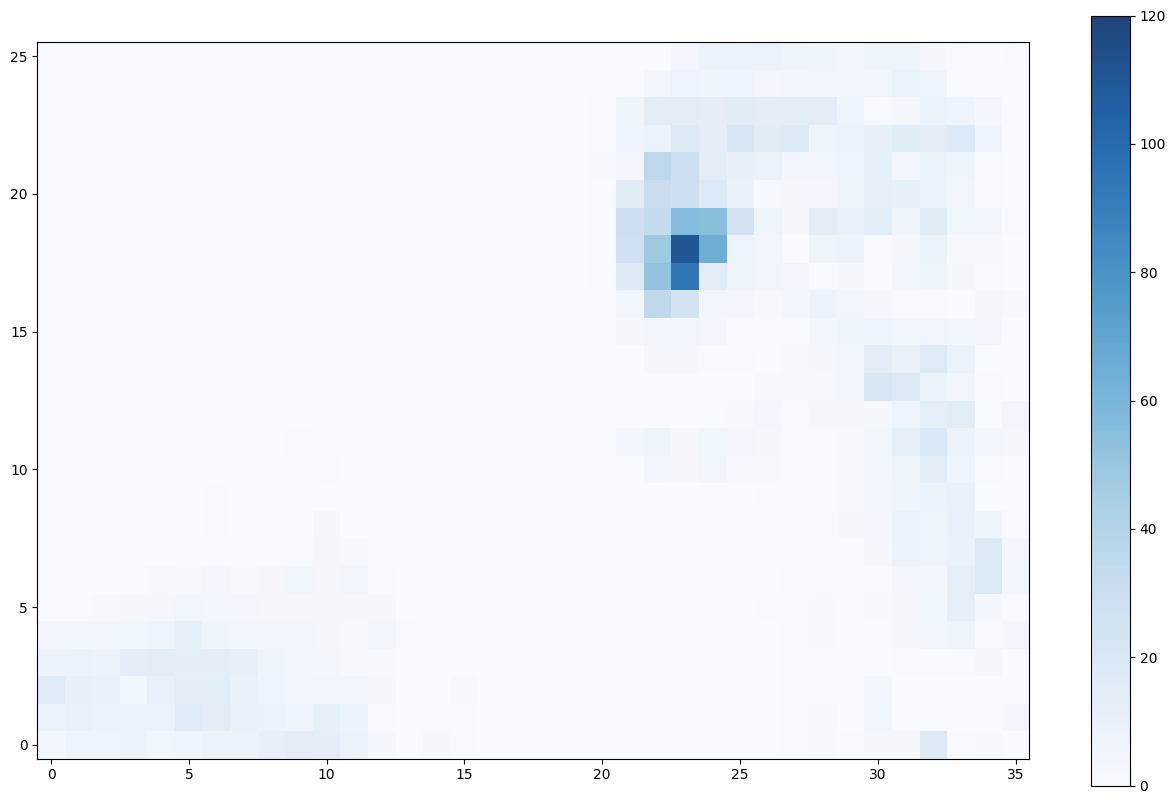

In [50]:
unperturbed_rain = targets.isel(batch=0, time=-1)["total_precipitation_12hr"].data
selected_rain = build_static_data_selector(inputs.coords, 5, 30, 65, 100)(unperturbed_rain) * 1000
selected_mask = build_static_data_selector(single_sample.coords, 5, 30, 65, 100)(single_sample["land_sea_mask"].data)[::-1, ...]
fig, ax = plt.subplots(figsize=(16,10))
# ax.imshow(selected_mask, extent=[0, 100-65, 0, 35-5])
im = ax.imshow(selected_rain, cmap="Blues", alpha=0.9, vmin=0, vmax=120)
ax.invert_yaxis()
fig.colorbar(im)
np.max(selected_rain)

In [83]:
variable_selector = lambda x: x["total_precipitation_12hr"]
region_selection_fn = build_static_data_selector(inputs.coords, 20, 25, 87, 92)

grads_fn = functools.partial(
    adv_grads_fn_jitted,
    region_selection_fn=region_selection_fn,
    variable_selection_fn=variable_selector
)

In [84]:
perturbation = our_attack(
    inputs,
    targets,
    forcings,
    0.07,
    grads_fn,
    maxiter=50,
    do_log=True,
)

0 0.014228106
1 0.011664225
2 0.0002816447
3 0.00766982
4 1.0742701e-05
5 0.0033477182
6 0.0001492118
7 -3.2586333e-05
8 -7.463218e-05
9 6.9215464e-05
10 0.003293848
11 9.166473e-06
12 3.5081488e-05
13 2.5752039e-08
14 -9.215545e-05
15 -0.00012221819
16 -0.00015179334
17 -0.000110450084
18 -0.00014925298
19 -0.00016565039
20 -2.845138e-05
21 -0.00017598816
22 -0.00017676309
23 -2.249721e-05
24 -0.00014957268
25 -9.8468656e-05
26 -0.0001469314
27 -0.00018951457
28 -0.00016892554
29 -0.00020673603
30 0.010052097
31 -0.00015879511
32 -0.000162297
33 0.0024974993
34 -0.00021316097
35 -2.4101148e-05
36 -0.00018900896
37 -0.00019453985
38 0.0005684919
39 -0.00018834391
40 -0.00014343217
41 -0.00015639127
42 -0.00016328343
43 0.0073397146
44 -0.0001824552
45 -7.813444e-06
46 0.0023160614
47 0.0005407851
48 -0.00021046467
49 7.0266164e-05


In [85]:
denoised_predictions = multi_step_forward_jit(
    jax.random.PRNGKey(1234567890),
    add_perturbation(inputs, perturbation),
    targets,
    forcings,
    forward_fn_jitted,
)

Array(35.671837, dtype=float32)

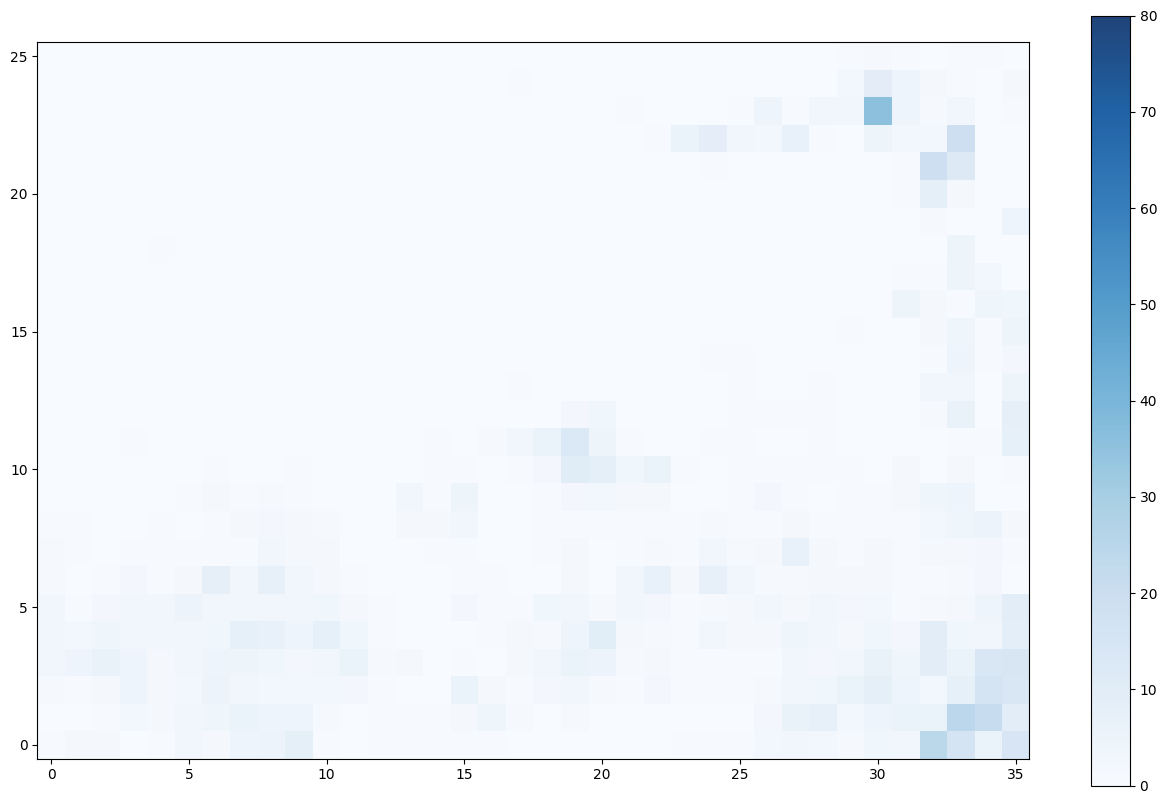

In [98]:
perturbed_rain = xarray_jax.unwrap_data(denoised_predictions.isel(batch=0, time=-1)["total_precipitation_12hr"])
selected_rain = build_static_data_selector(inputs.coords, 5, 30, 65, 100)(perturbed_rain) * 1000
selected_mask = build_static_data_selector(single_sample.coords, 5, 30, 65, 100)(single_sample["land_sea_mask"].data)[::-1, ...]
fig, ax = plt.subplots(figsize=(16,10))
# ax.imshow(selected_mask, extent=[0, 100-65, 0, 35-5])
im = ax.imshow(selected_rain, cmap="Blues", alpha=0.9, vmin=0, vmax=80)
ax.invert_yaxis()
fig.colorbar(im)
np.max(selected_rain)

In [102]:
import matplotlib

cmap = matplotlib.colormaps["Blues"]
def svg_heat_map(values):
    start_x = 65
    start_y = 0
    width = 50
    height = 35
    values = build_static_data_selector(inputs.coords, start_y, start_y+height, start_x, start_x+width)(values) * 1000
    
    def _to_hex_color(value):
        vmin = 0
        vmax = 63
        r,g,b,a = cmap((value - vmin) / (vmax - vmin))
        r = int(r * 255)
        g = int(g * 255)
        b = int(b * 255)
        return f"#{r:02x}{g:02x}{b:02x}"

    s = ""
    for dx in range(width):
        for dy in range(height):
            value = values[dy][dx]
            s += f'<rect width="1" height="1" x="{start_x+dx-0.5}" y="{-(start_y+dy)-0.5}" fill-opacity="{min(0.9, 0.9*(value/5))}" fill="{_to_hex_color(value)}" stroke="none"/>'
    return s

In [103]:
NEWLINE = "\n"
with open("data/results/rain_case_study_before.svg", "w") as f:
    f.write(f'''<svg viewBox="82 -31 12 15" xmlns="http://www.w3.org/2000/svg" style="stroke-width: 0.2%" clip-path="url(#clip)">
    <defs>
        <clipPath id="clip" clipPathUnits="userSpaceOnUse">
            <rect x="0" y="0" width="100%" height="100%" rx="1.1" ry="1"/>
        </clipPath>
    </defs>
    {NEWLINE.join(all_paths)}
    {svg_heat_map(unperturbed_rain)}
    <rect x="82" y="-31" width="12" height="15" rx="1.1" ry="1" stroke="black" fill="none"/>
</svg>''')

In [104]:
NEWLINE = "\n"
with open("data/results/rain_case_study_after.svg", "w") as f:
    f.write(f'''<svg viewBox="82 -31 12 15" xmlns="http://www.w3.org/2000/svg" style="stroke-width: 0.2%" clip-path="url(#clip)">
    <defs>
        <clipPath id="clip" clipPathUnits="userSpaceOnUse">
            <rect x="0" y="0" width="100%" height="100%" rx="1.1" ry="1"/>
        </clipPath>
    </defs>
    {NEWLINE.join(all_paths)}
    {svg_heat_map(perturbed_rain)}
    <rect width="5" height="6" stroke="#555" fill="none" y="-26" x="86" stroke-dasharray="1%"/>
    <rect x="82" y="-31" width="12" height="15" rx="1.1" ry="1" stroke="black" fill="none"/>
</svg>''')